In [1]:
import torch as tr
from mnist import MNIST
import numpy as np
from pylab import *
from matplotlib import colors
%matplotlib inline

mndata = MNIST('./data')

mndata.load_training()
img_side = 28
n_mnist_pixels = img_side*img_side

In [18]:
labels = tr.tensor(mndata.train_labels)

cluster_size = 10
train_inputs_idx = []
for idx in range(10):
    label_idx = tr.where(tr.isin(labels, tr.tensor([idx]) ))[0][:cluster_size]
    train_inputs_idx.append(label_idx)
samples_idx = tr.stack(train_inputs_idx).type(tr.int).flatten()
# samples_idx = np.array(train_inputs_idx, dtype='int').flatten()
samples_idx.size()


torch.Size([100])

In [44]:
layer_size = 10*4

I = tr.zeros(n_mnist_pixels)
O = tr.zeros(layer_size).type(tr.float)
W = tr.rand(O.size()[0], I.size()[0]).type(tr.float) * 0.001
print('W', W.shape, W.max(), W.min(), np.median(W))

k = 1
push_delta = 0.4

prec = 1e-30

epoch_cnt = 100
eps0 = 0.02

for epoch_idx in range(epoch_cnt):
    eps = (epoch_cnt - epoch_idx) * eps0

    # np.random.shuffle(samples_idx)

    for i_idx in samples_idx:
        img = mndata.train_images[i_idx]
        I = tr.from_numpy(np.array(img) / 255).type(tr.float)

        # infer
        O = tr.matmul(W, I)

        # train
        winner_ids = tr.argsort(O, descending=True)

        D = tr.zeros(O.shape)
        D[winner_ids[0]] = 1
        D[winner_ids[1:1+k]] = -push_delta
        D = D.reshape(1, D.size(0)).T

        O = O.reshape(1, O.size(0)).T
        dW = I - (W * O)

        # norm
        nc = tr.max(tr.abs(dW), dim=1).values
        # print(nc)
        # nc = np.linalg.norm(dW, axis=1, ord=1)
        nc[tr.where(nc < prec)] = prec
        nc = nc.reshape(1, nc.size(0)).T
        dW /= nc

        # update
        W += dW * D * eps

print('W', W.shape, W.max(), W.min(), np.median(W))

W torch.Size([40, 784]) tensor(0.0010) tensor(3.8147e-09) 0.00049528177
W torch.Size([40, 784]) tensor(0.4465) tensor(-2.7297) 0.0


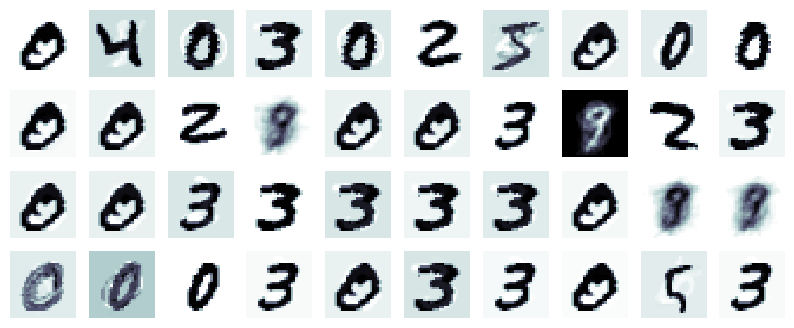

In [43]:
row_size = 10
col_size = int(layer_size / row_size)

figure(figsize=(row_size, col_size))

for col_idx in range(col_size):
    for row_idx in range(row_size):
        n_W_idx = col_idx * row_size + row_idx

        aimg = W[n_W_idx].reshape(img_side, img_side)

        subplot(col_size, row_size, n_W_idx + 1)

        imshow(aimg,
               interpolation='none',
               aspect='auto',
               cmap='bone',  # seismic
            #    vmax=1,
            #    vmin=-1,
               #    vmax=np.max(np.abs(aimg)),
               #    vmin=-np.max(np.abs(aimg))
               )
        axis("off")

show()